## Variational Autoencoders

when you’re building a generative model, you don’t want to replicate the same image you put into the network. You want to randomly sample from the latent space, or generate variations on an input image.



> The fundamental problem with autoencoders, for generation, is that the latent space they convert their inputs to and where their encoded vectors lie, may not be continuous, or allow easy interpolation.
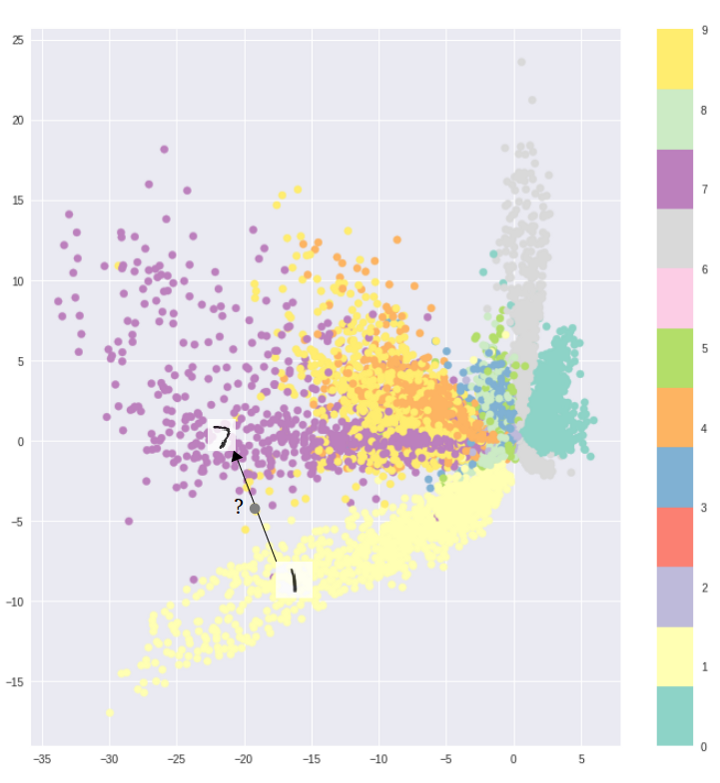



**Variational autoencoders** are a probabilistic version of autoencoders and their latent space are designed to be continuous, allowing easy random sampling and interpolation.



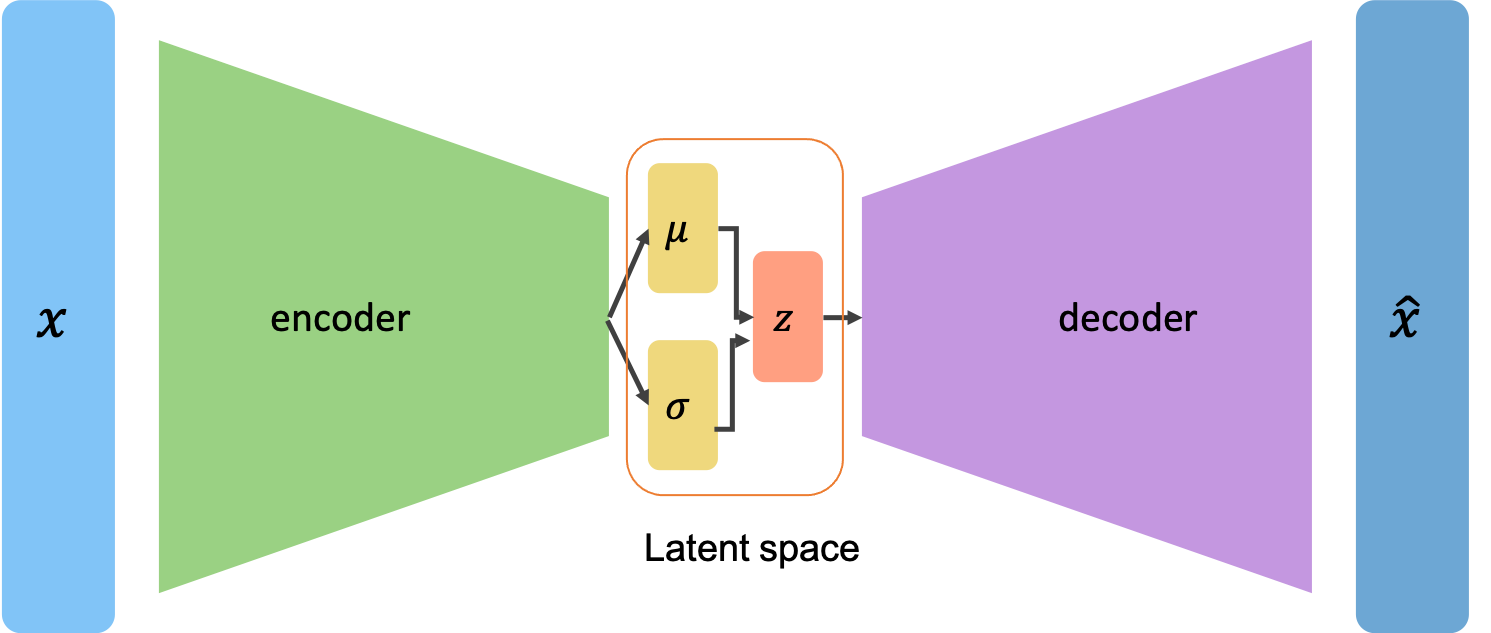

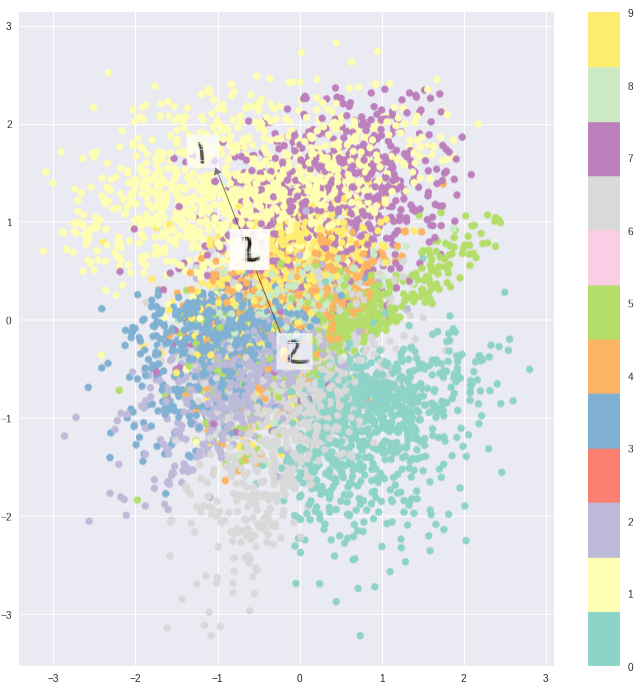

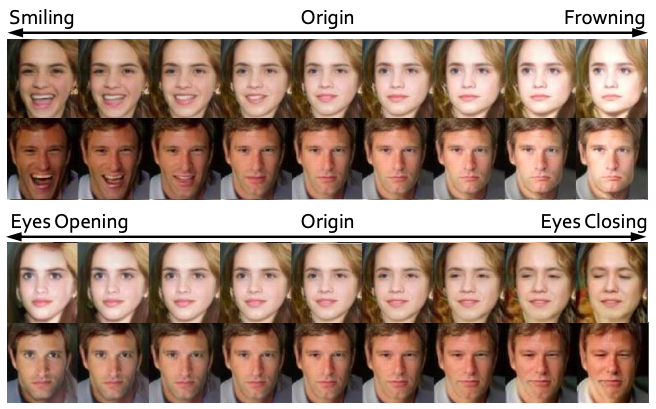

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype("float32") / 225.0
X_test = X_test.astype("float32") / 225.0

x_train = tf.expand_dims(X_train, axis=-1)
x_test = tf.expand_dims(X_test, axis=-1)

print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


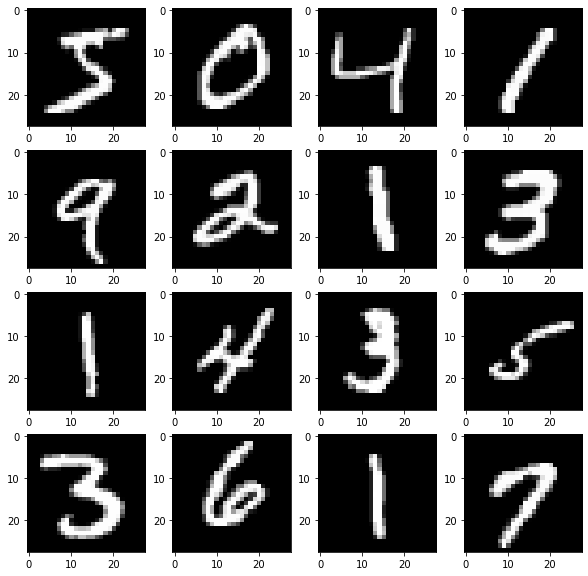

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) 

for i in range(16):
    plt.subplot(4,4,i+1)    
    plt.imshow(X_train[i], cmap='gray')

plt.show()

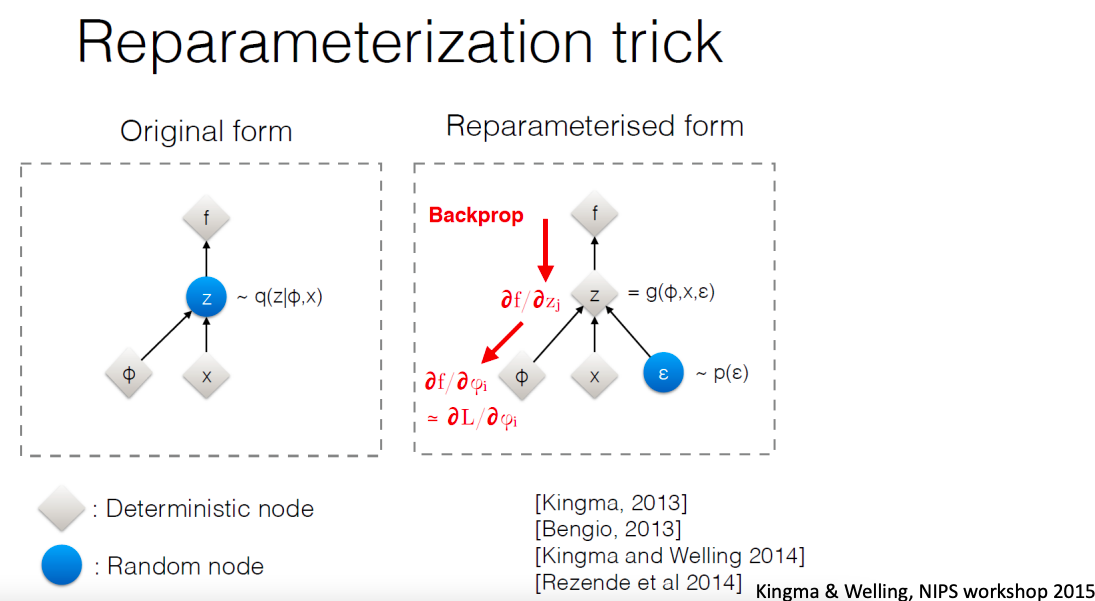

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the encoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation and the $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.



In [3]:
# Sampling layer

class Sampling(tf.keras.layers.Layer):

  def call(self, inputs):
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(sigma)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(0.5 * sigma) * epsilon

In [4]:
# Building the encoder

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, 3, activation="relu",
                           strides=2, padding="same")(encoder_inputs)

x = tf.keras.layers.Conv2D(64, 3, activation="relu",
                           strides=2, padding="same")(x)


x = tf.keras.layers.Flatten()(x)
x = layers.Dense(20, activation="relu")(x)


mu = tf.keras.layers.Dense(latent_dim, name="latent_mu")(x)
sigma = tf.keras.layers.Dense(latent_dim, name="latent_sigma")(x)
z = Sampling()([mu, sigma])

encoder = keras.Model(encoder_inputs, [mu, sigma, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [8]:
# Building the decoder

decoder_inputs = keras.Input(shape=(latent_dim,))
y = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)

y = tf.keras.layers.Reshape((7, 7, 64))(y)
y = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu",
                                    strides=2, padding="same")(y)
y = layers.Conv2DTranspose(32, 3, activation="relu",
                           strides=2, padding="same")(y)
                        

decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(y)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 



*   Adding the **Kullback–Leibler divergence (KL)** term into the loss function to inforce smoothness and continues interpolations.

*   The KL divergence between two probability distributions simply measures how much they diverge from each other.
> $ \sum_{i=1}^n \sigma_i^2 + \mu_i^2 - log (\sigma_i) -1 $


*   For VAEs, the KL loss is computed as the KL divergences between the encoded distribution component $z$, and the normal gaussian distribution with $\mu_i = 0$, $\sigma_i = 1$.
> **loss = reconstruction loss + KL divergence**









In [9]:
# Custum train_step()

class VAE(keras.Model):
  
  def __init__(self, encoder, decoder, **kwargs):
    
    super(VAE, self).__init__(**kwargs)

    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    
    return [self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker]

  def train_step(self, data):
  
    with tf.GradientTape() as tape:
      
      mu, sigma, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
      kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)

    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 5s 9ms/step - loss: 25029.2946 - reconstruction_loss: 228.7872 - kl_loss: 5557.2505
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 214.8435 - reconstruction_loss: 211.8283 - kl_loss: 2.6249
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 213.5887 - reconstruction_loss: 210.9624 - kl_loss: 2.4213
Epoch 4/5
469/469 [==============================] - 4s 9ms/step - loss: 212.6054 - reconstruction_loss: 209.9758 - kl_loss: 2.4722
Epoch 5/5
469/469 [==============================] - 4s 9ms/step - loss: 211.2560 - reconstruction_loss: 209.0698 - kl_loss: 2.3978


In [24]:
import numpy as np
z_sample = np.array([[0.1768, 0.289]])
x_decoded = vae.decoder.predict(z_sample)

1/1 [==============================] - 0s 16ms/step


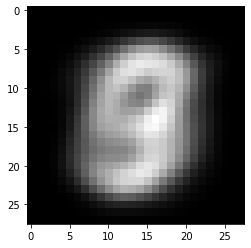

In [23]:
import matplotlib.pyplot as plt
plt.imshow(tf.reshape(x_decoded, (28, 28)), cmap='gray')